# ALBERT Sentiment Analysis Experiments on Sentiment 140 Dataset using baseline model (and with PEFT -- LoRA, BitFit, Prompt Tuning)

In [ ]:
"""We begin our process by installing packages such as pytorch, which is used extensively here, as well as HuggingFace's
transformers and datasets packages, which are used to run the ALBERT transformer model and load the Sentiment140 dataset, respectively. """

!pip install torch transformers datasets -q

In [ ]:
"""This step configures the credentials of the active user to seemlessly enable push and pull to and from the group's X-PERTS github repository"""

!git config --global credential.helper store

In [ ]:
"""We next import the installed packages, namely the ALBERT model"""

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

import time
from sklearn.metrics import classification_report

In [ ]:
""" We next instantiate (load) our temporary dataset, calling to our sentiment140.py script with a simple one-liner where this script handles the rest"""

dataset = load_dataset("./sentiment140.py", name="sentiment140")
full_train = dataset["train"]

print("Train size:", len(dataset["train"]))
print("Test size:", len(dataset["test"]))

In [ ]:
""" We next import a few packages for randomization of our sampling, re for text recognition and denoising and Datasets for creating our downsampled dataset"""

import random
import re
from datasets import Dataset

In [ ]:
""" With the entire 1.6m entry dataset loaded in as full_train above, we next filter out entries labelled 2 (a 'neutral' sentiment class label,
though there seemed not to be any such instances), and we define negative and positive tweets, from which we randomly sample 25k instances each for class balance.
We lastly overwrite our dataset with just the 50k class-balanced records from pre-processing to ensure fast, tractable training is possible run locally given
our resource-efficiency computationally-constrained focus."""

all_data = [x for x in full_train if x["sentiment"] in [0,4]]

negative = [x for x in all_data if x["sentiment"] == 0]
positive = [x for x in all_data if x["sentiment"] == 4]

random.seed(42)

negative_sample = random.sample(negative, 25000)
positive_sample = random.sample(positive, 25000)

sampled_data = negative_sample + positive_sample

random.shuffle(sampled_data)

dataset = Dataset.from_list(sampled_data)

In [ ]:
""" Next, with our 50k sentiment dataset, we perform pre-processing for standardization and to remove
noise in the form of mentions (e.g. @gatech), URLs (e.g. https://...), hashtags (e.g. #SwineFlu),
non-alphanumeric characters (e.g. emojis, capitalization, punctuation)"""

def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"@\w+", "", text)
  text = re.sub(r"#\w+", "", text)
  text = re.sub(r"[^a-z0-9\s]", "", text)
  return text.strip()

dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})

In [ ]:
model_name = "albert-base-v2"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, token=token)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
""" We apply mapping from the seemingly arbitrary 0,4 scale to 0,1 for standard binary classification"""

def map_labels(example):
    example["sentiment"] = 0 if example["sentiment"] == 0 else 1
    return example

dataset = dataset.map(map_labels)

print("Dataset size:", len(dataset))

from collections import Counter
print("Class distribution:", Counter(dataset["sentiment"]))

Map:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Map:   0%|          | 0/498 [00:00<?, ? examples/s]

DOWNSAMPLING FOR TRAINING

In [ ]:
""" We next perform downsampling and stratified splitting of the data 80/20 Train/Test """

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from collections import Counter
import pandas as pd

df = dataset.to_pandas()
df = df.dropna(subset=["text", "sentiment"])

print("Initial class distribution:", Counter(df["sentiment"]))

df_train, df_val_test = train_test_split(
    df,
    stratify=df["sentiment"],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))
print("Train class distribution:", Counter(df_train["sentiment"]))
print("Test class distribution:", Counter(df_test["sentiment"]))

train_dataset = Dataset.from_pandas(df_train).remove_columns(["__index_level_0__"])
test_dataset  = Dataset.from_pandas(df_test).remove_columns(["__index_level_0__"])

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "sentiment"])

tokenized_dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

160000
112000
24000
24000


Map:   0%|          | 0/112000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Train:     112000
Validation:24000
Test:      24000


In [ ]:
""" We print the head of each of the train/test sets to visualize our cleaned data"""

print("\nSample training examples:")
display(df_train.head(5))

print("\nSample test examples:")
display(df_test.head(5))

In [ ]:
""" We initialize our dataloader for each of the sets, fix their batch sizes
and randomize their order"""

train_loader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True)
test_loader  = DataLoader(tokenized_dataset["test"], batch_size=16)

In [ ]:
""" We define our optimizer using Adam and set a conservative learning rate and
weight decay (though later hyperparameter search will overwrite)"""

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=0.01
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

OPTForSequenceClassification(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): La


Test Accuracy   : 0.4466
F1 Score (macro): 0.4008
F1 Score (weighted): 0.4008
Inference Time  : 139.21s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.17      0.24     12000
    Positive       0.47      0.72      0.57     12000

    accuracy                           0.45     24000
   macro avg       0.42      0.45      0.40     24000
weighted avg       0.42      0.45      0.40     24000



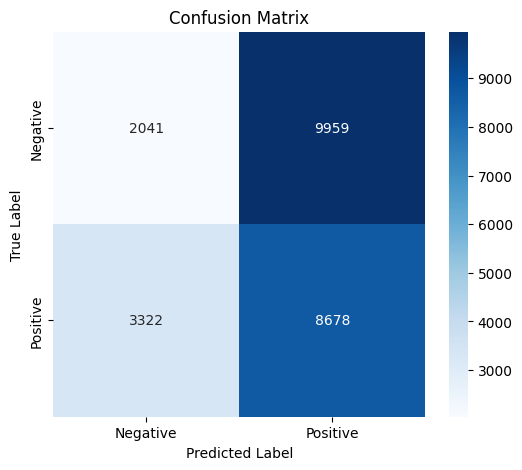

In [ ]:
""" Baseline inference for binary sentiment analysis task run on ALBERT
without PEFT (i.e. without BitFit and/or LoRA)"""

import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start


print(f'\nBaseline Inference Performance - ALBERT on Sentiment140\n')
print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Inference (ALBERT on Sentiment140)")
plt.show()

# LORA

In [ ]:
""" Install Parameter Efficient Finetuning Packages (e.g. LoRA and BitFit)"""

!pip install peft -q

In [ ]:
""" Importing LoRA packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [ ]:
""" LoRA parameter setup """

learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [ ]:
""" Training on ALBERT model using LoRA and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running LoRA with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # LoRA param update config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=16,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value"]
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)
            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ LoRA on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_albert_lora_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_albert_lora_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_albert_lora_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "LoRA",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_albert_lora_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["LoRA"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_albert_lora_final_comparison_lora.csv", index=False)

print("All LoRA Grid Search Results:")
for r in results:
    print(r)

print("\nBest LoRA Configuration:")
print(results[0])

In [ ]:
lora_best_lr = results[0]["learning_rate"]
lora_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_albert_lora_inference_metrics_summary_lr{lora_best_lr}_bs{lora_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_albert_lora_inference_predictions_lr{lora_best_lr}_bs{lora_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ LoRA on Sentiment140 \n")
plt.show()

NameError: name 'results' is not defined

# BITFIT

In [ ]:
""" Importing BitFit packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [ ]:
""" BitFit parameter setup """
learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [ ]:
""" Training on ALBERT model using BitFit and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running BitFit with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # BitFit param update config
        for name, param in model.named_parameters():
            if "bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ BitFit on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_albert_bitfit_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_albert_bitfit_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_albert_bitfit_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "BitFit",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_albert_bitfit_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["BitFit"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_albert_bf_final_comparison_bitfit.csv", index=False)

print("All BitFit Grid Search Results:")
for r in results:
    print(r)

print("\nBest BitFit Configuration:")
print(results[0])


In [ ]:
bf_best_lr = results[0]["learning_rate"]
bf_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_albert_bitfit_inference_metrics_summary_lr{bf_best_lr}_bs{bf_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_albert_bitfit_inference_predictions_lr{bf_best_lr}_bs{bf_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ BitFit on Sentiment140")
plt.show()

## Prompt Tuning

In [ ]:
""" Importing prompt tuning packages from PEFT """

import gc
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType

In [ ]:
""" Prompt tuning parameter setup """

lrs = [5e-5, 1e-4]
bs = [8, 16]
num_tokens = 20
epochs = 6

In [ ]:
""" Training and evaluation loop with hyperparamter grid search """

results = []

for lr in lrs:
    for batch_size in bs:
        print(f"Running Prompt Tuning with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # prompt tuning config
        peft_config = PromptTuningConfig(
            task_type=TaskType.SEQ_CLS,
            num_virtual_tokens=num_tokens,
            tokenizer_name_or_path=tokenizer.name_or_path,
            prompt_tuning_init=PromptTuningInit.RANDOM,
        )
        prompt_model = get_peft_model(model, peft_config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        prompt_model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimization
        optimizer = torch.optim.AdamW(prompt_model.parameters(), lr=lr)

        # begin training
        prompt_model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = prompt_model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            prompt_model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = prompt_model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - start_time

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            # print classification report on final epoch
            if epoch == epochs:
                total_correct = np.sum(np.array(y_true) == np.array(y_pred))
                total_samples = len(y_true)

                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: - ALBERT w/ Prompt Tuning on Sentiment140\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            prompt_model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"sent_albert_prompt_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # save inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"sent_albert_prompt_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # Save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"sent_albert_prompt_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "Prompt Tuning",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del prompt_model, model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("sent_albert_prompt_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["Prompt Tuning"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("sent_albert_prompt_final_comparison_prompt_tuning.csv", index=False)

print("All Prompt Tuning Grid Search Results:")
for r in results:
    print(r)

print("\nBest Configuration:")
print(results[0])

In [ ]:
prompt_best_lr = results[0]["learning_rate"]
prompt_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"sent_albert_prompt_inference_metrics_summary_lr{prompt_best_lr}_bs{prompt_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"sent_albert_prompt_inference_predictions_lr{prompt_best_lr}_bs{prompt_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ Prompt Tuning on Sentiment140\n")
plt.show()

##Begin Visualization of Sentiment140 Results

Load all dataframes from above training of 3 PEFT methods

In [ ]:
""" Output from our ALBERT_Sentiment140.ipynb file, we read in the .csv files here.
Note that these .csv file paths suggest they should be uploaded to session storage"""

# ALBERT PEFT-wise results across bf/lora/prompt tuning
albert_bf_results = pd.read_csv('/sent_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/sent_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/sent_albert_prompt_results.csv')

# ALBERT per-epoch performance logs (for LC generation) across bf/lora/prompt tuning
albert_lora_epochs_lr5_bs8 = pd.read_csv('/sent_albert_lora_epoch_logs_lr5e-05_bs8.csv')
albert_lora_epochs_lr5_bs16 = pd.read_csv('/sent_albert_lora_epoch_logs_lr5e-05_bs16.csv')
albert_lora_epochs_lr1_bs8 = pd.read_csv('/sent_albert_lora_epoch_logs_lr1e-04_bs8.csv')
albert_lora_epochs_lr1_bs16 = pd.read_csv('/sent_albert_lora_epoch_logs_lr1e-04_bs16.csv')
albert_bf_epochs_lr5_bs8 = pd.read_csv('/sent_albert_bitfit_epoch_logs_lr5e-05_bs8.csv')
albert_bf_epochs_lr5_bs16 = pd.read_csv('/sent_albert_bitfit_epoch_logs_lr5e-05_bs16.csv')
albert_bf_epochs_lr1_bs8 = pd.read_csv('/sent_albert_bitfit_epoch_logs_lr1e-04_bs8.csv')
albert_bf_epochs_lr1_bs16 = pd.read_csv('/sent_albert_bitfit_epoch_logs_lr1e-04_bs16.csv')
albert_prompt_epochs_lr5_bs8 = pd.read_csv('/sent_albert_prompt_epoch_logs_lr5e-05_bs8.csv')
albert_prompt_epochs_lr5_bs16 = pd.read_csv('/sent_albert_prompt_epoch_logs_lr5e-05_bs16.csv')
albert_prompt_epochs_lr1_bs8 = pd.read_csv('/sent_albert_prompt_epoch_logs_lr1e-04_bs8.csv')
albert_prompt_epochs_lr1_bs16 = pd.read_csv('/sent_albert_prompt_epoch_logs_lr1e-04_bs16.csv')

# ALBERT inference performance metric summary across bf/lora/prompt tuning
albert_bf_inf_lr5_bs8 = pd.read_csv('/sent_albert_bitfit_inference_metrics_summary_lr5e-05_bs8.csv')
albert_bf_inf_lr5_bs16 = pd.read_csv('/sent_albert_bitfit_inference_metrics_summary_lr5e-05_bs16.csv')
albert_bf_inf_lr1_bs8 = pd.read_csv('/sent_albert_bitfit_inference_metrics_summary_lr1e-04_bs8.csv')
albert_bf_inf_lr1_bs16 = pd.read_csv('/sent_albert_bitfit_inference_metrics_summary_lr1e-04_bs16.csv')
albert_lora_inf_lr5_bs8 = pd.read_csv('/sent_albert_lora_inference_metrics_summary_lr5e-05_bs8.csv')
albert_lora_inf_lr5_bs16 = pd.read_csv('/sent_albert_lora_inference_metrics_summary_lr5e-05_bs16.csv')
albert_lora_inf_lr1_bs8 = pd.read_csv('/sent_albert_lora_inference_metrics_summary_lr1e-04_bs8.csv')
albert_lora_inf_lr1_bs16 = pd.read_csv('/sent_albert_lora_inference_metrics_summary_lr1e-04_bs16.csv')
albert_prompt_inf_lr5_bs8 = pd.read_csv('/sent_albert_prompt_inference_metrics_summary_lr5e-05_bs8.csv')
albert_prompt_inf_lr5_bs16 = pd.read_csv('/sent_albert_prompt_inference_metrics_summary_lr5e-05_bs16.csv')
albert_prompt_inf_lr1_bs8 = pd.read_csv('/sent_albert_prompt_inference_metrics_summary_lr1e-04_bs8.csv')
albert_prompt_inf_lr1_bs16 = pd.read_csv('/sent_albert_prompt_inference_metrics_summary_lr1e-04_bs16.csv')

# ALBERT inference predictions across bf/lora/prompt tuning
albert_bf_preds_lr5_bs8 = pd.read_csv('/sent_albert_bitfit_inference_predictions_lr5e-05_bs8.csv')
albert_bf_preds_lr5_bs16 = pd.read_csv('/sent_albert_bitfit_inference_predictions_lr5e-05_bs16.csv')
albert_bf_preds_lr1_bs8 = pd.read_csv('/sent_albert_bitfit_inference_predictions_lr1e-04_bs8.csv')
albert_bf_preds_lr1_bs16 = pd.read_csv('/sent_albert_bitfit_inference_predictions_lr1e-04_bs16.csv')
albert_lora_preds_lr5_bs8 = pd.read_csv('/sent_albert_lora_inference_predictions_lr5e-05_bs8.csv')
albert_lora_preds_lr5_bs16 = pd.read_csv('/sent_albert_lora_inference_predictions_lr5e-05_bs16.csv')
albert_lora_preds_lr1_bs8 = pd.read_csv('/sent_albert_lora_inference_predictions_lr1e-04_bs8.csv')
albert_lora_preds_lr1_bs16 = pd.read_csv('/sent_albert_lora_inference_predictions_lr1e-04_bs16.csv')
albert_prompt_preds_lr5_bs8 = pd.read_csv('/sent_albert_prompt_inference_predictions_lr5e-05_bs8.csv')
albert_prompt_preds_lr5_bs16 = pd.read_csv('/sent_albert_prompt_inference_predictions_lr5e-05_bs16.csv')
albert_prompt_preds_lr1_bs8 = pd.read_csv('/sent_albert_prompt_inference_predictions_lr1e-04_bs8.csv')
albert_prompt_preds_lr1_bs16 = pd.read_csv('/sent_albert_prompt_inference_predictions_lr1e-04_bs16.csv')

# ALBERT PEFT method intra-comparison based on hyperparameter settings, per bf/lora/prompt tuning
albert_bf_final_comparison = pd.read_csv('/sent_albert_bf_final_comparison_bitfit.csv')
albert_lora_final_comparison = pd.read_csv('/sent_albert_lora_final_comparison_lora.csv')
albert_prompt_final_comparison = pd.read_csv('/sent_albert_prompt_final_comparison_prompt_tuning.csv')

BitFit Learning Curves

In [ ]:
# All BitFit Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ BitFit on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ BitFit on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Best BitFit Train/Val Acc Learning Curve

albert_bf_epochs_map = {
    (5, 8): albert_bf_epochs_lr5_bs8,
    (5, 16): albert_bf_epochs_lr5_bs16,
    (1, 8): albert_bf_epochs_lr1_bs8,
    (1, 16): albert_bf_epochs_lr1_bs16
}

bf_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

bf_best_lr_tag = bf_lr_mapping[bf_best_lr]
bf_best_bs_tag = bf_best_bs

bf_epochs = albert_bf_epochs_map[(bf_best_lr_tag, bf_best_bs_tag)]

# Best BitFit Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=bf_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ BitFit on Sentiment140\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=bf_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ BitFit on Sentiment140\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

LoRA Learning Curves

In [ ]:
# All LoRA Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ LoRA on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ LoRA on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Best LoRA Train/Val Acc Learning Curve

albert_lora_epochs_map = {
    (5, 8): albert_lora_epochs_lr5_bs8,
    (5, 16): albert_lora_epochs_lr5_bs16,
    (1, 8): albert_lora_epochs_lr1_bs8,
    (1, 16): albert_lora_epochs_lr1_bs16
}

lora_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

lora_best_lr_tag = lora_lr_mapping[lora_best_lr]
lora_best_bs_tag = lora_best_bs

lora_epochs = albert_lora_epochs_map[(lora_best_lr_tag, lora_best_bs_tag)]

# Best LoRA Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=lora_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ LoRA on Sentiment140\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=lora_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ LoRA on Sentiment140\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Prompt Tuning Learning Curves

In [ ]:
# All Prompt Tuning Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ Prompt Tuning on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ Prompt Tuning on Sentiment140")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Best Prompt Tuning Train/Val Acc Learning Curve

albert_prompt_epochs_map = {
    (5, 8): albert_prompt_epochs_lr5_bs8,
    (5, 16): albert_prompt_epochs_lr5_bs16,
    (1, 8): albert_prompt_epochs_lr1_bs8,
    (1, 16): albert_prompt_epochs_lr1_bs16
}

prompt_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

prompt_best_lr_tag = prompt_lr_mapping[prompt_best_lr]
prompt_best_bs_tag = prompt_best_bs

prompt_epochs = albert_prompt_epochs_map[(prompt_best_lr_tag, prompt_best_bs_tag)]

# Best Prompt Tuning Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ Prompt Tuning on Sentiment140\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ Prompt Tuning on Sentiment140\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

PEFT Method Comparison:

In [ ]:
# Final results per BitFit/LoRA/Prompt Tuning Implementation

albert_bf_results = pd.read_csv('/sent_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/sent_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/sent_albert_prompt_results.csv')

# Table of comparisons
comparison = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Best Validation F1": [
        albert_bf_results["f1"].max(),
        albert_lora_results["f1"].max(),
        albert_prompt_results["f1"].max()
    ],
    "Best Validation Accuracy": [
        albert_bf_results["accuracy"].max(),
        albert_lora_results["accuracy"].max(),
        albert_prompt_results["accuracy"].max()
    ],
    "Runtime (sec)": [
        albert_bf_results["training_time"].sum(),
        albert_lora_results["training_time"].sum(),
        albert_prompt_results["training_time"].sum()
    ],
    "Inference Time (sec)": [
        albert_bf_results["inference_time"].sum(),
        albert_lora_results["inference_time"].sum(),
        albert_prompt_results["inference_time"].sum()
    ],
    "Max GPU Memory (GB)": [
        albert_bf_results["max_memory"].max(),
        albert_lora_results["max_memory"].max(),
        albert_prompt_results["max_memory"].max()
    ]
})

print("\nFinal Validation Performance PEFT Comparison - ALBERT on Sentiment140:")
display(comparison)


In [ ]:
# Load best inference metric summaries
bf_best_lr_tag

bf_inf = pd.read_csv(f'/sent_albert_bitfit_inference_metrics_summary_lr{bf_best_lr_tag}_bs{bf_best_bs}.csv')
lora_inf = pd.read_csv(f'/sent_albert_lora_inference_metrics_summary_lr{lora_best_lr_tag}_bs{lora_best_bs}.csv')
prompt_inf = pd.read_csv(f'/sent_albert_prompt_inference_metrics_summary_lr{prompt_best_lr_tage}_bs{prompt_best_bs}.csv')

# Table of best per-implementation metrics (based on best lr and bs per PEFT method)
final_test_results = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Test Accuracy": [
        bf_inf.loc[0, "accuracy"],
        lora_inf.loc[0, "accuracy"],
        prompt_inf.loc[0, "accuracy"]
    ],
    "F1 Macro": [
        bf_inf.loc[0, "f1_macro"],
        lora_inf.loc[0, "f1_macro"],
        prompt_inf.loc[0, "f1_macro"]
    ],
    "F1 Weighted": [
        bf_inf.loc[0, "f1_weighted"],
        lora_inf.loc[0, "f1_weighted"],
        prompt_inf.loc[0, "f1_weighted"]
    ],
    "Inference Time (sec)": [
        bf_inf.loc[0, "inference_time_sec"],
        lora_inf.loc[0, "inference_time_sec"],
        prompt_inf.loc[0, "inference_time_sec"]
    ]
})

print("\nFinal Test Set Inference Performance PEFT Comparison - ALBERT on Sentiment140:")
display(final_test_results)

# ALBERT Sentiment Analysis Experiments on IMDb 50k Dataset using baseline model (and with PEFT -- LoRA, BitFit, Prompt Tuning)

In [ ]:
"""We begin our process by installing packages such as pytorch, which is used extensively here, as well as HuggingFace's
transformers and datasets packages, which are used to run the ALBERT transformer model and load the IMDb 50k dataset, respectively. """

!pip install torch transformers datasets -q

In [ ]:
"""This step configures the credentials of the active user to seemlessly enable push and pull to and from the group's X-PERTS github repository"""

!git config --global credential.helper store

In [ ]:
"""We next import the installed packages, namely the ALBERT model """

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

import time
from sklearn.metrics import classification_report, f1_score

In [ ]:
""" We next instantiate (load) our IMDb 50k dataset"""

dataset_imdb = load_dataset("imdb")

full_imdb = concatenate_datasets([dataset_imdb["train"], dataset_imdb["test"]])

full_imdb_split = full_imdb.train_test_split(test_size=0.2, seed=42)

full_train = full_imdb_split["train"]
dataset = {"test": full_imdb_split["test"]}

print("Train size:", len(full_train))
print("Test size:", len(dataset["test"]))

SyntaxError: closing parenthesis '}' does not match opening parenthesis '[' (<ipython-input-1-ff561ea81177>, line 10)

In [ ]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = full_train.map(tokenize, batched=True)
tokenized_test = dataset["test"].map(tokenize, batched=True)

tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

tokenized_dataset = {"train": tokenized_train, "test": tokenized_test}

In [ ]:
model_name = "albert-base-v2"
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
""" We print the head of each of the train/test sets to visualize our cleaned data"""

print("\nSample training examples:")
display(full_train[:5])

print("\nSample test examples:")
display(dataset["test"][:5])

In [ ]:
""" We initialize our dataloader for each of the sets, fix their batch sizes
and randomize their order"""

train_loader = DataLoader(tokenized_dataset["train"], batch_size=16, shuffle=True)
test_loader  = DataLoader(tokenized_dataset["test"], batch_size=16, shuffle=False)


Test Accuracy   : 0.4466
F1 Score (macro): 0.4008
F1 Score (weighted): 0.4008
Inference Time  : 139.21s

Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.17      0.24     12000
    Positive       0.47      0.72      0.57     12000

    accuracy                           0.45     24000
   macro avg       0.42      0.45      0.40     24000
weighted avg       0.42      0.45      0.40     24000



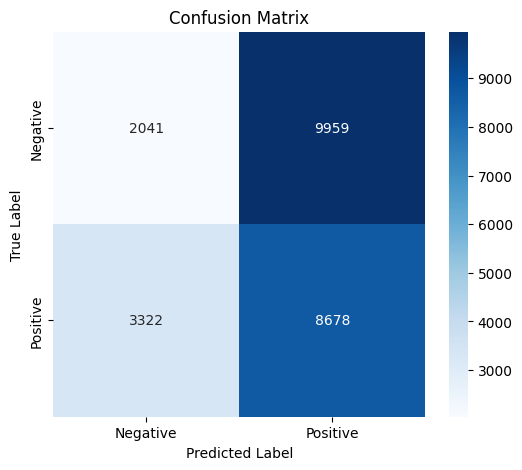

In [ ]:
""" Baseline inference for binary sentiment analysis task run on ALBERT
without PEFT (i.e. without BitFit and/or LoRA)"""

import time
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

inference_start = time.time()

model.eval()
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
f1_macro = f1_score(all_labels, all_preds, average="macro")
f1_weighted = f1_score(all_labels, all_preds, average="weighted")
inference_time = time.time() - inference_start

print(f'\nBaseline Inference Performance - ALBERT on IMDb50k\n')
print(f"\nTest Accuracy   : {accuracy:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Inference Time  : {inference_time:.2f}s")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Inference (ALBERT on IMDb50k)")
plt.show()

# LORA

In [ ]:
""" Install Parameter Efficient Finetuning Packages (e.g. LoRA and BitFit)"""

!pip install peft -q

In [ ]:
""" Importing LoRA packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [ ]:
""" LoRA parameter setup """

learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [ ]:
""" Training on ALBERT model using LoRA and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running LoRA with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # LoRA param update config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=16,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=["query", "key", "value"]
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)
            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ LoRA on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_lora_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_lora_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_lora_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "LoRA",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_lora_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["LoRA"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_lora_final_comparison_lora.csv", index=False)

print("All LoRA Grid Search Results:")
for r in results:
    print(r)

print("\nBest LoRA Configuration:")
print(results[0])

In [ ]:
lora_best_lr = results[0]["learning_rate"]
lora_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_lora_inference_metrics_summary_lr{lora_best_lr}_bs{lora_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_lora_inference_predictions_lr{lora_best_lr}_bs{lora_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ LoRA on IMDb50k")
plt.show()

NameError: name 'results' is not defined

# BITFIT

In [ ]:
""" Importing BitFit packages """

import gc
import torch
import time
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import classification_report, f1_score
from torch.utils.data import DataLoader

In [ ]:
""" BitFit parameter setup """
learning_rates = [5e-5, 1e-4]
batch_sizes = [8, 16]
epochs = 6

In [ ]:
""" Training on ALBERT model using BitFit and output dataset generation (saved as .csv)"""

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Running BitFit with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # BitFit param update config
        for name, param in model.named_parameters():
            if "bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimizer
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # begin training
        model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            inference_start = time.time()
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - inference_start

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            if epoch == epochs:
                total_correct = sum(yt == yp for yt, yp in zip(y_true, y_pred))
                total_samples = len(y_true)
                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ BitFit on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_bitfit_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # saver inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_bitfit_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_bitfit_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "BitFit",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "inference_time": inference_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_bitfit_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["BitFit"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Inference Time (s)": [results[0]["inference_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_bf_final_comparison_bitfit.csv", index=False)

print("All BitFit Grid Search Results:")
for r in results:
    print(r)

print("\nBest BitFit Configuration:")
print(results[0])


In [ ]:
bf_best_lr = results[0]["learning_rate"]
bf_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_bitfit_inference_metrics_summary_lr{bf_best_lr}_bs{bf_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_bitfit_inference_predictions_lr{bf_best_lr}_bs{bf_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ BitFit on IMDb50k")
plt.show()

## Prompt Tuning

In [ ]:
""" Importing prompt tuning packages from PEFT """

import gc
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType

In [ ]:
""" Prompt tuning parameter setup """

lrs = [5e-5, 1e-4]
bs = [8, 16]
num_tokens = 20
epochs = 6

In [ ]:
""" Training and evaluation loop with hyperparamter grid search """

results = []

for lr in lrs:
    for batch_size in bs:
        print(f"Running Prompt Tuning with LR={lr}, batch_size={batch_size}")

        # loading ALBERT model
        model_name = "albert-base-v2"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # prompt tuning config
        peft_config = PromptTuningConfig(
            task_type=TaskType.SEQ_CLS,
            num_virtual_tokens=num_tokens,
            tokenizer_name_or_path=tokenizer.name_or_path,
            prompt_tuning_init=PromptTuningInit.RANDOM,
        )
        prompt_model = get_peft_model(model, peft_config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        prompt_model.to(device)

        # instantiate dataloader
        data_collator = DataCollatorWithPadding(tokenizer)
        train_dataloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
        test_dataloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=data_collator)

        # adam optimization
        optimizer = torch.optim.AdamW(prompt_model.parameters(), lr=lr)

        # begin training
        prompt_model.train()
        start_time = time.time()
        epoch_logs = []

        for epoch in range(1, epochs + 1):
            running_loss = 0.0
            correct = 0
            total = 0
            loop = tqdm(train_dataloader, leave=False)
            for step, batch in enumerate(loop):
                if step >= 300:
                    break
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = prompt_model(**batch)
                loss = outputs.loss
                preds = torch.argmax(outputs.logits, dim=1)
                correct += (preds == batch['labels']).sum().item()
                total += batch['labels'].size(0)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / (step + 1)
            train_accuracy = correct / total

            # perform per epoch evaluation
            prompt_model.eval()
            val_running_loss = 0.0
            y_true, y_pred = [], []
            with torch.no_grad():
                for batch in test_dataloader:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = prompt_model(**batch)
                    preds = torch.argmax(outputs.logits, dim=1)
                    y_true.extend(batch["labels"].cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    val_running_loss += outputs.loss.item()

            avg_val_loss = val_running_loss / len(test_dataloader)

            inference_time = time.time() - start_time

            report = classification_report(y_true, y_pred, output_dict=True)
            val_accuracy = report["accuracy"]
            val_f1 = report["weighted avg"]["f1-score"]

            # print classification report on final epoch
            if epoch == epochs:
                total_correct = np.sum(np.array(y_true) == np.array(y_pred))
                total_samples = len(y_true)

                accuracy = total_correct / total_samples
                f1_macro = f1_score(y_true, y_pred, average="macro")
                f1_weighted = f1_score(y_true, y_pred, average="weighted")

                print(f"\n[Final Epoch {epoch}] Inference Metrics:")
                print(f"Test Accuracy      : {accuracy:.4f}")
                print(f"F1 Score (macro)   : {f1_macro:.4f}")
                print(f"F1 Score (weighted): {f1_weighted:.4f}")
                print(f"Inference Time     : {inference_time:.2f} seconds")
                print("\nClassification Report: ALBERT w/ Prompt Tuning on IMDb50k\n")
                print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

            epoch_logs.append({
                "epoch": epoch,
                "lr": lr,
                "batch_size": batch_size,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy
            })

            prompt_model.train()

        end_time = time.time()
        training_time = end_time - start_time

        # begin datalogging per lr/bs
        epoch_logs_df = pd.DataFrame(epoch_logs)
        epoch_logs_df.to_csv(f"imdb_albert_prompt_epoch_logs_lr{lr}_bs{batch_size}.csv", index=False)

        # save inference metrics per lr/bs
        metrics_summary_df = pd.DataFrame(report).transpose()
        metrics_summary_df.to_csv(f"imdb_albert_prompt_inference_metrics_summary_lr{lr}_bs{batch_size}.csv", index=True)

        # Save inference predictions for the final epoch
        predictions_df = pd.DataFrame({
            "y_true": y_true,
            "y_pred": y_pred
        })
        predictions_df.to_csv(f"imdb_albert_prompt_inference_predictions_lr{lr}_bs{batch_size}.csv", index=False)

        # log memory usage
        max_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) if torch.cuda.is_available() else 0

        # save model params and metrics
        results.append({
            "method": "Prompt Tuning",
            "learning_rate": lr,
            "batch_size": batch_size,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "training_time": training_time,
            "max_memory": max_memory
        })

        # empty cache to conserve compute
        del prompt_model, model, tokenizer, optimizer
        torch.cuda.empty_cache()
        gc.collect()

# ranked performance by val acc
results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

# save overall results
results_df = pd.DataFrame(results)
results_df.to_csv("imdb_albert_prompt_results.csv", index=False)

# save best final config and metrics
final_summary_df = pd.DataFrame({
    "Method": ["Prompt Tuning"],
    "Best LR": [results[0]["learning_rate"]],
    "Best Batch Size": [results[0]["batch_size"]],
    "Accuracy": [results[0]["accuracy"]],
    "F1 Score": [results[0]["f1"]],
    "Training Time (s)": [results[0]["training_time"]],
    "Max GPU Memory (GB)": [results[0]["max_memory"]]
})
final_summary_df.to_csv("imdb_albert_prompt_final_comparison_prompt_tuning.csv", index=False)

print("All Prompt Tuning Grid Search Results:")
for r in results:
    print(r)

print("\nBest Configuration:")
print(results[0])

In [ ]:
prompt_best_lr = results[0]["learning_rate"]
prompt_best_bs = results[0]["batch_size"]

# Construct filename
best_report_file = f"imdb_albert_prompt_inference_metrics_summary_lr{prompt_best_lr}_bs{prompt_best_bs}.csv"

# Load the saved best report
best_report_df = pd.read_csv(best_report_file)
print("\nClassification Report for Best Configuration:")
print(best_report_df)


best_preds_df = pd.read_csv(f"imdb_albert_prompt_inference_predictions_lr{prompt_best_lr}_bs{prompt_best_bs}.csv")
print("\nInference Predictions for Best Configuration:")
print(best_preds_df)

y_true = best_preds_df["y_true"]
y_pred = best_preds_df["y_pred"]


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ALBERT w/ Prompt Tuning on IMDb50k")
plt.show()

##Begin Visualization of IMDb 50k Results

Load all dataframes from above training of 3 PEFT methods

In [ ]:
""" Output from our ALBERT_Sentiment140_IMDb50k.ipynb file, we read in the .csv files here.
Note that these .csv file paths suggest they should be uploaded to session storage"""

# ALBERT PEFT-wise results across bf/lora/prompt tuning
albert_bf_results = pd.read_csv('/imdb_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/imdb_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/imdb_albert_prompt_results.csv')

# ALBERT per-epoch performance logs (for LC generation) across bf/lora/prompt tuning
albert_lora_epochs_lr5_bs8 = pd.read_csv('/imdb_albert_lora_epoch_logs_lr5e-05_bs8.csv')
albert_lora_epochs_lr5_bs16 = pd.read_csv('/imdb_albert_lora_epoch_logs_lr5e-05_bs16.csv')
albert_lora_epochs_lr1_bs8 = pd.read_csv('/imdb_albert_lora_epoch_logs_lr1e-04_bs8.csv')
albert_lora_epochs_lr1_bs16 = pd.read_csv('/imdb_albert_lora_epoch_logs_lr1e-04_bs16.csv')
albert_bf_epochs_lr5_bs8 = pd.read_csv('/imdb_albert_bitfit_epoch_logs_lr5e-05_bs8.csv')
albert_bf_epochs_lr5_bs16 = pd.read_csv('/imdb_albert_bitfit_epoch_logs_lr5e-05_bs16.csv')
albert_bf_epochs_lr1_bs8 = pd.read_csv('/imdb_albert_bitfit_epoch_logs_lr1e-04_bs8.csv')
albert_bf_epochs_lr1_bs16 = pd.read_csv('/imdb_albert_bitfit_epoch_logs_lr1e-04_bs16.csv')
albert_prompt_epochs_lr5_bs8 = pd.read_csv('/imdb_albert_prompt_epoch_logs_lr5e-05_bs8.csv')
albert_prompt_epochs_lr5_bs16 = pd.read_csv('/imdb_albert_prompt_epoch_logs_lr5e-05_bs16.csv')
albert_prompt_epochs_lr1_bs8 = pd.read_csv('/imdb_albert_prompt_epoch_logs_lr1e-04_bs8.csv')
albert_prompt_epochs_lr1_bs16 = pd.read_csv('/imdb_albert_prompt_epoch_logs_lr1e-04_bs16.csv')

# ALBERT inference performance metric summary across bf/lora/prompt tuning
albert_bf_inf_lr5_bs8 = pd.read_csv('/imdb_albert_bitfit_inference_metrics_summary_lr5e-05_bs8.csv')
albert_bf_inf_lr5_bs16 = pd.read_csv('/imdb_albert_bitfit_inference_metrics_summary_lr5e-05_bs16.csv')
albert_bf_inf_lr1_bs8 = pd.read_csv('/imdb_albert_bitfit_inference_metrics_summary_lr1e-04_bs8.csv')
albert_bf_inf_lr1_bs16 = pd.read_csv('/imdb_albert_bitfit_inference_metrics_summary_lr1e-04_bs16.csv')
albert_lora_inf_lr5_bs8 = pd.read_csv('/imdb_albert_lora_inference_metrics_summary_lr5e-05_bs8.csv')
albert_lora_inf_lr5_bs16 = pd.read_csv('/imdb_albert_lora_inference_metrics_summary_lr5e-05_bs16.csv')
albert_lora_inf_lr1_bs8 = pd.read_csv('/imdb_albert_lora_inference_metrics_summary_lr1e-04_bs8.csv')
albert_lora_inf_lr1_bs16 = pd.read_csv('/imdb_albert_lora_inference_metrics_summary_lr1e-04_bs16.csv')
albert_prompt_inf_lr5_bs8 = pd.read_csv('/imdb_albert_prompt_inference_metrics_summary_lr5e-05_bs8.csv')
albert_prompt_inf_lr5_bs16 = pd.read_csv('/imdb_albert_prompt_inference_metrics_summary_lr5e-05_bs16.csv')
albert_prompt_inf_lr1_bs8 = pd.read_csv('/imdb_albert_prompt_inference_metrics_summary_lr1e-04_bs8.csv')
albert_prompt_inf_lr1_bs16 = pd.read_csv('/imdb_albert_prompt_inference_metrics_summary_lr1e-04_bs16.csv')

# ALBERT inference predictions across bf/lora/prompt tuning
albert_bf_preds_lr5_bs8 = pd.read_csv('/imdb_albert_bitfit_inference_predictions_lr5e-05_bs8.csv')
albert_bf_preds_lr5_bs16 = pd.read_csv('/imdb_albert_bitfit_inference_predictions_lr5e-05_bs16.csv')
albert_bf_preds_lr1_bs8 = pd.read_csv('/imdb_albert_bitfit_inference_predictions_lr1e-04_bs8.csv')
albert_bf_preds_lr1_bs16 = pd.read_csv('/imdb_albert_bitfit_inference_predictions_lr1e-04_bs16.csv')
albert_lora_preds_lr5_bs8 = pd.read_csv('/imdb_albert_lora_inference_predictions_lr5e-05_bs8.csv')
albert_lora_preds_lr5_bs16 = pd.read_csv('/imdb_albert_lora_inference_predictions_lr5e-05_bs16.csv')
albert_lora_preds_lr1_bs8 = pd.read_csv('/imdb_albert_lora_inference_predictions_lr1e-04_bs8.csv')
albert_lora_preds_lr1_bs16 = pd.read_csv('/imdb_albert_lora_inference_predictions_lr1e-04_bs16.csv')
albert_prompt_preds_lr5_bs8 = pd.read_csv('/imdb_albert_prompt_inference_predictions_lr5e-05_bs8.csv')
albert_prompt_preds_lr5_bs16 = pd.read_csv('/imdb_albert_prompt_inference_predictions_lr5e-05_bs16.csv')
albert_prompt_preds_lr1_bs8 = pd.read_csv('/imdb_albert_prompt_inference_predictions_lr1e-04_bs8.csv')
albert_prompt_preds_lr1_bs16 = pd.read_csv('/imdb_albert_prompt_inference_predictions_lr1e-04_bs16.csv')

# ALBERT PEFT method intra-comparison based on hyperparameter settings, per bf/lora/prompt tuning
albert_bf_final_comparison = pd.read_csv('/imdb_albert_bf_final_comparison_bitfit.csv')
albert_lora_final_comparison = pd.read_csv('/imdb_albert_lora_final_comparison_lora.csv')
albert_prompt_final_comparison = pd.read_csv('/imdb_albert_prompt_final_comparison_prompt_tuning.csv')


BitFit Learning Curves

In [ ]:
# All BitFit Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ BitFit on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_bf_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ BitFit on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Best BitFit Train/Val Acc Learning Curve

albert_bf_epochs_map = {
    (5, 8): albert_bf_epochs_lr5_bs8,
    (5, 16): albert_bf_epochs_lr5_bs16,
    (1, 8): albert_bf_epochs_lr1_bs8,
    (1, 16): albert_bf_epochs_lr1_bs16
}

bf_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

bf_best_lr_tag = bf_lr_mapping[bf_best_lr]
bf_best_bs_tag = bf_best_bs

bf_epochs = albert_bf_epochs_map[(bf_best_lr_tag, bf_best_bs_tag)]

# Best BitFit Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=bf_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ BitFit on IMDb50k\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best BitFit Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=bf_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=bf_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ BitFit on IMDb50k\nBest Hyperparameters: LR: {bf_best_lr} and BS: {bf_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

LoRA Learning Curves

In [ ]:
# All LoRA Train/Val Acc Learning Curve (ALBERT)
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ LoRA on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All LoRA Training and Validation Loss (ALBERT)
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_lora_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ LoRA on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Best LoRA Train/Val Acc Learning Curve

albert_lora_epochs_map = {
    (5, 8): albert_lora_epochs_lr5_bs8,
    (5, 16): albert_lora_epochs_lr5_bs16,
    (1, 8): albert_lora_epochs_lr1_bs8,
    (1, 16): albert_lora_epochs_lr1_bs16
}

lora_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

lora_best_lr_tag = lora_lr_mapping[lora_best_lr]
lora_best_bs_tag = lora_best_bs

lora_epochs = albert_lora_epochs_map[(lora_best_lr_tag, lora_best_bs_tag)]

# Best LoRA Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=lora_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ LoRA on IMDb50k\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best LoRA Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=lora_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=lora_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ LoRA on IMDb50k\nBest Hyperparameters: LR: {lora_best_lr} and BS: {lora_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Prompt Tuning Learning Curves

In [ ]:
# All Prompt Tuning Train/Val Acc Learning Curve
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_accuracy", label="TA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_accuracy", label="VA_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_accuracy", label="TA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_accuracy", label="VA_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_accuracy", label="TA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_accuracy", label="VA_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_accuracy", label="TA_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_accuracy", label="VA_lr1_bs16")
plt.title("Learning Curve: Accuracy - ALBERT w/ Prompt Tuning on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# All Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="train_loss", label="TL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs8, x="epoch", y="val_loss", label="VL_lr5_bs8")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="train_loss", label="TL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr5_bs16, x="epoch", y="val_loss", label="VL_lr5_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="train_loss", label="TL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs8, x="epoch", y="val_loss", label="VL_lr1_bs8")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="train_loss", label="TL_lr1_bs16")
sns.lineplot(data=albert_prompt_epochs_lr1_bs16, x="epoch", y="val_loss", label="VL_lr1_bs16")
plt.title("Learning Curve: Loss - ALBERT w/ Prompt Tuning on IMDb50k")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Best Prompt Tuning Train/Val Acc Learning Curve

albert_prompt_epochs_map = {
    (5, 8): albert_prompt_epochs_lr5_bs8,
    (5, 16): albert_prompt_epochs_lr5_bs16,
    (1, 8): albert_prompt_epochs_lr1_bs8,
    (1, 16): albert_prompt_epochs_lr1_bs16
}

prompt_lr_mapping = {
    5e-5: 5,
    1e-4: 1
}

prompt_best_lr_tag = prompt_lr_mapping[prompt_best_lr]
prompt_best_bs_tag = prompt_best_bs

prompt_epochs = albert_prompt_epochs_map[(prompt_best_lr_tag, prompt_best_bs_tag)]

# Best Prompt Tuning Training and Validation Accuracy
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_accuracy", label="Training Accuracy")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title(f"Learning Curve: Best Accuracy - ALBERT w/ Prompt Tuning on IMDb50k\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Best Prompt Tuning Training and Validation Loss
plt.figure(figsize=(10,5))
sns.lineplot(data=prompt_epochs, x="epoch", y="train_loss", label="Training Loss")
sns.lineplot(data=prompt_epochs, x="epoch", y="val_loss", label="Validation Loss")
plt.title(f"Learning Curve: Best Loss - ALBERT w/ Prompt Tuning on IMDb50k\nBest Hyperparameters: LR: {prompt_best_lr} and BS: {prompt_best_bs}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

PEFT Method Comparison:

In [ ]:
# Final results per BitFit/LoRA/Prompt Tuning Implementation

albert_bf_results = pd.read_csv('/imdb_albert_bitfit_results.csv')
albert_lora_results = pd.read_csv('/imdb_albert_lora_results.csv')
albert_prompt_results = pd.read_csv('/imdb_albert_prompt_results.csv')

# Table of comparisons
comparison = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Best Validation F1": [
        albert_bf_results["f1"].max(),
        albert_lora_results["f1"].max(),
        albert_prompt_results["f1"].max()
    ],
    "Best Validation Accuracy": [
        albert_bf_results["accuracy"].max(),
        albert_lora_results["accuracy"].max(),
        albert_prompt_results["accuracy"].max()
    ],
    "Runtime (sec)": [
        albert_bf_results["training_time"].sum(),
        albert_lora_results["training_time"].sum(),
        albert_prompt_results["training_time"].sum()
    ],
    "Inference Time (sec)": [
        albert_bf_results["inference_time"].sum(),
        albert_lora_results["inference_time"].sum(),
        albert_prompt_results["inference_time"].sum()
    ],
    "Max GPU Memory (GB)": [
        albert_bf_results["max_memory"].max(),
        albert_lora_results["max_memory"].max(),
        albert_prompt_results["max_memory"].max()
    ]
})

print("\nFinal Validation Performance PEFT Comparison - ALBERT on IMDb50k:")
display(comparison)


In [ ]:
# Load best inference metric summaries
bf_best_lr_tag

bf_inf = pd.read_csv(f'/imdb_albert_bitfit_inference_metrics_summary_lr{bf_best_lr_tag}_bs{bf_best_bs}.csv')
lora_inf = pd.read_csv(f'/imdb_albert_lora_inference_metrics_summary_lr{lora_best_lr_tag}_bs{lora_best_bs}.csv')
prompt_inf = pd.read_csv(f'/imdb_albert_prompt_inference_metrics_summary_lr{prompt_best_lr_tage}_bs{prompt_best_bs}.csv')

# Table of best per-implementation metrics (based on best lr and bs per PEFT method)
final_test_results = pd.DataFrame({
    "Method": ["BitFit", "LoRA", "Prompt Tuning"],
    "Test Accuracy": [
        bf_inf.loc[0, "accuracy"],
        lora_inf.loc[0, "accuracy"],
        prompt_inf.loc[0, "accuracy"]
    ],
    "F1 Macro": [
        bf_inf.loc[0, "f1_macro"],
        lora_inf.loc[0, "f1_macro"],
        prompt_inf.loc[0, "f1_macro"]
    ],
    "F1 Weighted": [
        bf_inf.loc[0, "f1_weighted"],
        lora_inf.loc[0, "f1_weighted"],
        prompt_inf.loc[0, "f1_weighted"]
    ],
    "Inference Time (sec)": [
        bf_inf.loc[0, "inference_time_sec"],
        lora_inf.loc[0, "inference_time_sec"],
        prompt_inf.loc[0, "inference_time_sec"]
    ]
})

print("\nFinal Test Set Inference Performance PEFT Comparison - ALBERT on IMDb50k:")
display(final_test_results)